# Mixture Density Networks

Biship's 1994 [paper](http://eprints.aston.ac.uk/373/1/NCRG_94_004.pdf)

Combines a conventinal neural network with a mixture density model. 

## Notation

$X = {x_1, \cdots, x_d}$ : input variables

$t = {t_1, \cdots, t_c}$ : output/target variables

$c$ : output dimension

$t_k$ : components of the target vector

$q$ : training sample index, $\{x^q, t^q\}$.

$m$ : number of components in the mixture. 

Output size: $(c + 2) \times m$

$\alpha_i(X)$ : mixing coefficients, can be regarded as prior probabilities, conditioned on $X$, of the target vector $t$ having been generated from the $i^{th}$ component of the mixture. Note that $\sum_{i=1}^{m} \alpha_i (X) = 1$, achieved by using softmax.

$\phi_i (t \mid X)$ : conditional density of the target vector $t$ for the $i^{th}$ kernel. The paper uses Gaussian kernel.


## Description

The probability density of the target data is represented as **a linear combination of kernel functions** in the form:

$$ p(t \mid X) = \sum_{i=1}^{m} \alpha_i (X) \phi_i (t \mid X) $$

A Gaussian mixture model can approximate **any** given density function to arbitary accuracy, **provided that the mixing coefficient and the Gaussian parameters (means and variances) are correctly chosen** (McLachlan and Basformd, 1989). It does not assume that the component of $t$ are statistically independent, in contrast to the single Gaussian representation. 

By choosing a mixture model with a **sufficient** number of kernel functions, and a NN with a **sufficient** number of hidden units, the MDN can approximate as closely as desired **any** conditional density $p(t \mid x)$.

## Loss Function

Loss function is given by:

$$
\begin{aligned}
E &= \sum_q E^q \\
E^q &= -\ln \bigg \{ \sum_{i=1}^m \alpha_i (X^q) \phi_i (t^q \mid X^q) \bigg \}
\end{aligned}
$$

For Gaussian kernels (Gaussian PDF):

$$ \phi_i (t \mid X) = \frac{1}{(2\pi)^{c/2}\sigma_i(X)^c} \exp\bigg\{ -\frac{\| t - \mu_i(X) \|^2}{2\sigma_i(X)^2} \bigg\} $$

## Network Architecture

Credits to this great [repo](https://github.com/hardmaru/pytorch_notebooks) from @hardmaru.

MDN uses a NN to output 3 groups of parameters: $\alpha_i(X)$, $\mu, \sigma$ for $\phi_i(X)$. 

Loss is computed based on these parameters. 

## Sampling from a MDN

we can sample from the distributions parameterised by outputs from a MDN. This is done in **two** steps as pointed out [here](https://stats.stackexchange.com/questions/243392/generate-sample-data-from-gaussian-mixture-model):

1. Sample from the **discrete** distribution parameterized by $\alpha_i(X)$, denoted by $\it{I}$. This is done by the [alias method](http://keithschwarz.com/darts-dice-coins/). Thanks for two posts that pointed this out, [here](https://stats.stackexchange.com/questions/67911/how-to-sample-from-a-discrete-distribution) and [here](https://stats.stackexchange.com/questions/26858/how-to-generate-numbers-based-on-an-arbitrary-discrete-distribution).
2. Sample from $\phi_{\it{I}}(X)$, e.g. the $\it{I}^{th}$ normal distribution.

The code for **alias method** can be found [here](https://stats.stackexchange.com/questions/67911/how-to-sample-from-a-discrete-distribution). It is also used by @hardmaru in his post in function `get_pi_idx()`.

My implementation below `sample_discrete()` is sligtly faster for not super large number of categories.

## Implementation

Here I try to implement a MDN that supports multivariate Gaussian distributions, i.e. it predicts the full covariance matrix, rather than a single variance or assuming equal variance across dimensions.



As of March 2018, `pytorch` will only have matrix determinant support in `0.4`, which means Gaussian PDF cannot be easily done... 

However, `tensorflow` already has this support, check out [`tf.contrib.distributions.MultivariateNormalTriL()`](https://www.tensorflow.org/api_docs/python/tf/contrib/distributions/MultivariateNormalTriL) and see the example there on how to compute pdf. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

import torch
import torch.nn as nn

from torch.autograd import Variable

In [2]:
def sample_discrete(pdf, x=None):
    '''
    Alias method to draw samples from discrete distributions based on
    uneven probabilities.
    
    This method is slightly faster than the original one. 200ms vs 360ms, 
    with 20 discrete categories.
    
    Parameters:
    ------------------------------
    pdf: numpy.ndarray
        Probablity density, must be all positive and sum to 1. This defines
        the probabilities of the discrete distribution. In repeated draws,
        the returned index result will approximate this probability 
        distribution.
    x: float
        probability, must be non-negative. If not given a random number
        is generated.
        
    Returns:
        One sample of index position.
    '''
    assert(np.all(pdf >= 0)), 'Not all elements are >= 0.'
    
    cs = pdf.cumsum()
    assert(np.isclose(cs[-1], 1)), 'PDF does not sum to 1.'
    
    if x is None:
        # generate uniform random number [0, 1)
        x = np.random.rand()
    else:
        assert x >= 0
    
    idx = np.where(cs >= x)[0]
    if len(idx) < 1:
        print('error with sampling ensemble')
        return -1
    else:
        return idx[0]

In [4]:
# example to demostrate that this samples according to a given PDF

pdf = np.array([.1, .2, .1, .3, .3])
N = 10000
xs = np.random.rand(N)
samples = []

for i in range(N):
    idx = sample_discrete(pdf, x=xs[i])
    samples.append(idx)

samples = pd.Series(samples)
est = samples.groupby(samples).count() / N

print('Expected Probabilities: ', pdf)
print('Sampled Probabilities:')
print(est)

Expected Probabilities:  [0.1 0.2 0.1 0.3 0.3]
Sampled Probabilities:
0    0.0990
1    0.2008
2    0.1030
3    0.2957
4    0.3015
dtype: float64


In [5]:
# etf = pd.read_hdf('/home/zwl/data/etf.h5', key='close')
# spy = etf['SPY US Equity']
# spy = np.log(spy) - np.log(spy.shift(1))
# spy = spy.dropna()
# spy.to_hdf('./spy.h5', key='rtns')

In [3]:
spy = pd.read_hdf('./data/spy.h5', key='rtns')

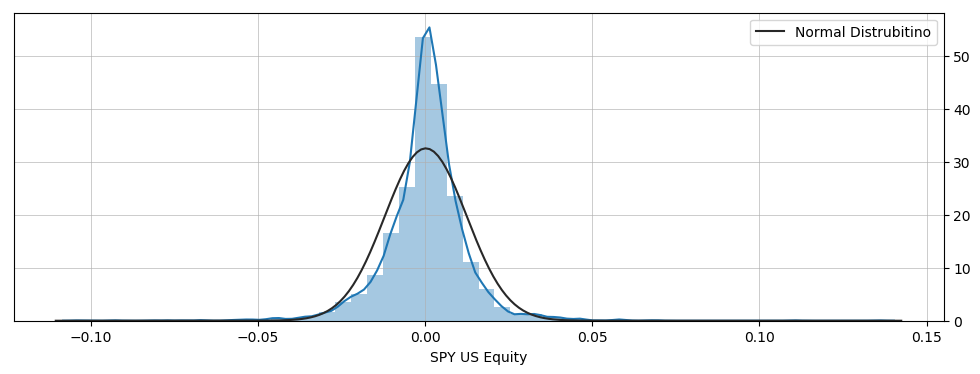

In [4]:
ax = sns.distplot(spy, fit=stats.norm, fit_kws={'label': 'Normal Distrubitino'})
ax.legend(loc='best')

In [5]:
def choose_activation(activation):
    # determine activation function
    if activation == 'relu':
        act_func = nn.ReLU()
    elif activation == 'selu':
        act_func = nn.SELU()
    elif activation == 'tanh':
        act_func = nn.Tanh()
    elif activation == 'sigmoid':
        act_func = nn.Sigmoid()
    else:
        act_func = None

    return act_func


class MDN(nn.Module):
    def __init__(self, input_dims, output_dim, num_mixtures, bias=True, act='tanh'):
        super(MDN, self).__init__()
        
        assert(act in {'tanh', 'linear', 'relu'})
        
        self.input_dims = input_dims
        self.output_dim = output_dim
        self.num_layers = len(input_dims)
        self.num_mixtures = num_mixtures
        
        num_layers = len(input_dims)
        # output would be alpha_i, mu_i and sigma_i, for i in range(output_dim)
        # if sigma is full covariance matrix, then sigma_i size is output_dim^2
        # then replicate this for N mixtures
        num_params = num_mixtures + (output_dim + output_dim * output_dim) * num_mixtures

        # use separate networks for the 3 groups of parameters.
        
        self.activation_fn = choose_activation(act)
        
        # alpha, mixture weights, size: num_mixtures
        if num_layers > 1:
            self.alpha_layers = [nn.Linear(input_dims[i], input_dims[i+1], bias=bias) 
                                 for i in range(num_layers - 1)]
            self.alpha_layers.append(nn.Linear(input_dims[-1], num_mixtures, bias=bias))
        else:
            self.alpha_layers = [nn.Linear(input_dims[0], num_mixtures, bias=bias)]
            
        # mu, means, size: output_dim * num_mixtures
        mu_size = output_dim * num_mixtures
        if num_layers > 1:
            self.mu_layers = [nn.Linear(input_dims[i], input_dims[i+1], bias=bias) 
                                 for i in range(num_layers - 1)]
            self.mu_layers.append(nn.Linear(input_dims[-1], mu_size, bias=bias))
        else:
            self.mu_layers = [nn.Linear(input_dims[0], mu_size, bias=bias)]
        
        # sigma, covariance square matrix, size: output_dim^2 * num_mixtures
        sigma_size = output_dim**2 * num_mixtures
        if num_layers > 1:
            self.sigma_layers = [nn.Linear(input_dims[i], input_dims[i+1], bias=bias) 
                                 for i in range(num_layers - 1)]
            self.sigma_layers.append(nn.Linear(input_dims[-1], sigma_size, bias=bias))
        else:
            self.alpha_layers = [nn.Linear(input_dims[0], sigma_size, bias=bias)]
        
    def forward(self, X):
        # initialize
        alpha, mu, sigma = X, X, X
        
        for i in range(self.num_layers):
            alpha = self.alpha_layers[i](alpha)
            if i < self.num_layers - 1:
                alpha = self.activation_fn(alpha)
        
        for i in range(self.num_layers):
            mu = self.mu_layers[i](mu)
            if i < self.num_layers - 1:
                mu = self.activation_fn(mu)
                
        for i in range(self.num_layers):
            sigma = self.sigma_layers[i](sigma)
            if i < self.num_layers - 1:
                sigma = self.activation_fn(sigma)
            
        return alpha, mu, sigma

In [6]:
mdn = MDN([10, 10], 2, 3)
mdn

MDN(
  (activation_fn): Tanh()
)

In [19]:
x = torch.FloatTensor(1, 10)

In [20]:
x


1.00000e-29 *
  7.1360  0.0000  0.0032  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x10]

In [30]:
x = torch.FloatTensor([[2, 2],[5, 6]])

In [27]:
x = Variable(x)

In [28]:
x.inverse()

Variable containing:
 3.0000 -1.0000
-2.5000  1.0000
[torch.FloatTensor of size 2x2]

In [33]:
alpha, mu, sigma = mdn(x)

In [34]:
alpha

Variable containing:
 0.2606 -0.4027  0.2997
[torch.FloatTensor of size 1x3]

In [35]:
mu

Variable containing:
 0.3092  0.0555  0.2153  0.0879  0.4331  0.0821
[torch.FloatTensor of size 1x6]

In [36]:
sigma

Variable containing:

Columns 0 to 9 
 0.3290  0.2645 -0.4358 -0.0438  0.0625 -0.0194  0.4167  0.0351  0.0935 -0.3444

Columns 10 to 11 
 0.3638 -0.0299
[torch.FloatTensor of size 1x12]

## Loss Function

Loss function is given by:

$$
\begin{aligned}
E &= \sum_q E^q \\
E^q &= -\ln \bigg \{ \sum_{i=1}^m \alpha_i (X^q) \phi_i (t^q \mid X^q) \bigg \}
\end{aligned}
$$

For Gaussian kernels (Gaussian PDF):

$$ \phi_i (t \mid X) = \frac{1}{(2\pi)^{c/2}\sigma_i(X)^c} \exp\bigg\{ -\frac{\| t - \mu_i(X) \|^2}{2\sigma_i(X)^2} \bigg\} $$

Gaussian PDF for $ X = [X_1, \cdots, X_n]^T$:

$$ p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2}\mid \Sigma \mid^{1/2}} \exp\bigg( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)) \bigg)$$

In [24]:
def gaussian_pdf(y, mu, sigma):
    '''
    Multi-variable Gaussian PDF.
    '''
    _, y_dim = y.shape
    c = 1 / (2 * np.pi)**(y_dim / 2)
    # compute determine, currently this is not in pytorch 0.3.1, coming in 0.4
    c = c * torch.pow(torch.reciprocal(sigma.det()), 1/2)
    
    z = y.expand_as(mu) - mu
    # pytorch reloads @ operator to torch.mm()
    z = -.5 * torch.transpose(z) @ sigma.inverse() @ z
    z = torch.exp(z)
    z = c * z
    
    return z

In [32]:
def mdn_loss(alpha, sigma, mu, y):
    z = gaussian_pdf(y, mu, sigma) * alpha
    z = torch.sum(z, dim=1)
    z = - torch.log(z)
    return torch.mean(z)